In [2]:
# Imports
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle
import gc
import torch.utils.data as data_utils
from sklearn.metrics import accuracy_score
import evaluate
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Configuration
base_model = 'roberta-base'
fixed_rank = 4 # LoRA rank
fixed_alpha_scale = 1
fixed_alpha = fixed_rank * fixed_alpha_scale # LoRA alpha

output_directory = "roberta_agnews_finetuned"
current_output_dir = output_directory
unlabelled_data_path = "test_unlabelled.pkl" 

os.makedirs(current_output_dir, exist_ok=True)
print(f"Output directory set to: {current_output_dir}")
print(f"Unlabelled data path: {unlabelled_data_path}")

Output directory set to: roberta_agnews_finetuned
Unlabelled data path: test_unlabelled.pkl


In [4]:
# Load Data & Tokenizer
print("Loading AG News dataset and RoBERTa tokenizer...")
dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

print("Dataset and tokenizer loaded.")
print(dataset)

Loading AG News dataset and RoBERTa tokenizer...


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Dataset and tokenizer loaded.
Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})


In [5]:
# Preprocessing Function
def preprocess(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

print("Preprocessing function defined.")

Preprocessing function defined.


In [6]:
# Tokenize & Prepare Data
print("Tokenizing dataset...")
# Apply tokenization, remove original text column, rename label column
tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels") # Rename for Trainer compatibility

# Dataset Info
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"Number of labels: {num_labels}, Labels: {class_names}")
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in id2label.items()}

# Data Collator
# Handles dynamic padding within batches
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt") # pt for PyTorch tensors

print("Dataset tokenized and prepared.")
print(tokenized_dataset)

Tokenizing dataset...


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Number of labels: 4, Labels: ['World', 'Sports', 'Business', 'Sci/Tech']
Dataset tokenized and prepared.
Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 120000
})


In [7]:
# Split Data
print("Splitting dataset into train/validation...")
# Create a validation set (1280 samples)
split_datasets = tokenized_dataset.train_test_split(test_size=1280, seed=42, stratify_by_column="labels")
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(eval_dataset)}")

Splitting dataset into train/validation...
Train samples: 118720, Validation samples: 1280


In [8]:
# Metrics & Evaluation Function

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    return {'accuracy': accuracy}

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inference_model.to(device)
    inference_model.eval() # Set model to evaluation mode

    all_predictions = []
    metric = None
    metric_load_error = False

    if labelled:
        try:
            metric = evaluate.load('accuracy')
        except Exception as e:
            print(f"Warning: Could not load accuracy metric: {e}. Accuracy will not be computed.")
            metric_load_error = True

    print(f"Starting evaluation (Labelled: {labelled})...")
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        # Move batch tensors to the correct device
        batch_on_device = {}
        try:
            for k, v in batch.items():
                batch_on_device[k] = v.to(device) if isinstance(v, torch.Tensor) else v
        except Exception as e:
            print(f"ERROR moving batch to device: {e}")
            continue

        # Prepare inputs for the model
        model_input_batch = {k: v for k, v in batch_on_device.items() if k != 'labels'}

        # Perform inference
        with torch.no_grad():
            try:
                outputs = inference_model(**model_input_batch)
            except TypeError as e:
                # Handle case where model might expect 'labels' even during eval
                if 'labels' in str(e) and 'labels' in batch_on_device:
                    try:
                        outputs = inference_model(**batch_on_device)
                    except Exception as e2:
                        print(f"ERROR: Model forward pass failed even with labels: {e2}")
                        continue
                else:
                    print(f"ERROR: Model forward pass failed: {e}")
                    continue
            except Exception as e:
                print(f"ERROR during model forward pass: {e}")
                continue

        predictions = outputs.logits.argmax(dim=-1).cpu()
        all_predictions.append(predictions)

        if labelled and not metric_load_error and metric is not None and "labels" in batch:
            references = batch["labels"]
            if isinstance(references, torch.Tensor):
                references = references.cpu().numpy()
            try:
                metric.add_batch(predictions=predictions.numpy(), references=references)
            except Exception as e:
                print(f"ERROR adding batch to metric: {e}")

    # Process results
    if not all_predictions:
        print("WARNING: No predictions generated.")
        return ({}, torch.tensor([])) if labelled else torch.tensor([])

    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = {}
        if not metric_load_error and metric is not None:
            try:
                eval_metric = metric.compute()
                if not eval_metric:
                    print("Warning: metric.compute() returned empty result.")
                    eval_metric = {}
            except Exception as e:
                print(f"CRITICAL ERROR computing metric: {e}")
                eval_metric = {}
        return eval_metric, all_predictions
    else:
        # Unlabelled data: return only predictions
        return all_predictions

print("Metrics and Evaluation functions defined.")

Metrics and Evaluation functions defined.


In [9]:
# Training Setup

# 1. Load Base Model
print("Loading base model for fine-tuning...")
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)
if torch.cuda.is_available():
    print("Moving base model to CUDA")
    model.to('cuda')
else:
    print("CUDA not available or disabled, using CPU.")

# 2. Configure LoRA
print(f"Configuring LoRA with r={fixed_rank}, alpha={fixed_alpha}")
peft_config = LoraConfig(
    r=fixed_rank,
    lora_alpha=fixed_alpha,
    lora_dropout=0.2,
    target_modules=["query", "key", "value"],
    bias="none",
    task_type="SEQ_CLS", 
)

# 3. Apply PEFT (LoRA) to the Model
print("Applying PEFT (LoRA) to the base model...")
peft_model = get_peft_model(model, peft_config)
print("PEFT Model Configured. Trainable parameters:")
peft_model.print_trainable_parameters() # Show number of trainable LoRA parameters

# 4. Define Training Arguments
training_args = TrainingArguments(
    output_dir=current_output_dir,
    report_to="none",               
    eval_strategy="steps",          
    eval_steps=200,                 
    logging_steps=100,              
    learning_rate=1e-5,
    max_steps=2000,                
    use_cpu=not torch.cuda.is_available(),
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    optim="adamw_torch",
    load_best_model_at_end=True,    
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_strategy="steps",          
    save_steps=200,                 
    save_total_limit=2              # Keep only the latest + best checkpoints
)

# 5. Initialize Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,     
    data_collator=data_collator,
    tokenizer=tokenizer
)

print("Training setup complete. Trainer initialized.")

Loading base model for fine-tuning...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Moving base model to CUDA


/tmp/ipykernel_227/3826758230.py:56: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Configuring LoRA with r=4, alpha=4
Applying PEFT (LoRA) to the base model...
PEFT Model Configured. Trainable parameters:
trainable params: 814,852 || all params: 125,463,560 || trainable%: 0.6495
Training setup complete. Trainer initialized.


Starting training...


Step,Training Loss,Validation Loss,Accuracy
200,1.376900,1.373308,0.434375
400,1.360400,1.355043,0.483594
600,1.333900,1.322613,0.823438
800,1.272100,1.257064,0.871875
1000,1.156000,1.116064,0.885938
1200,0.973800,0.879489,0.876563
1400,0.717200,0.640513,0.882812
1600,0.592600,0.515445,0.889844
1800,0.525700,0.467153,0.892969
2000,0.512400,0.454448,0.892188


Training finished.
Trained LoRA adapter saved to roberta_agnews_finetuned
Plotting loss curves...
Loss curves saved to: roberta_agnews_finetuned/loss_curves.png


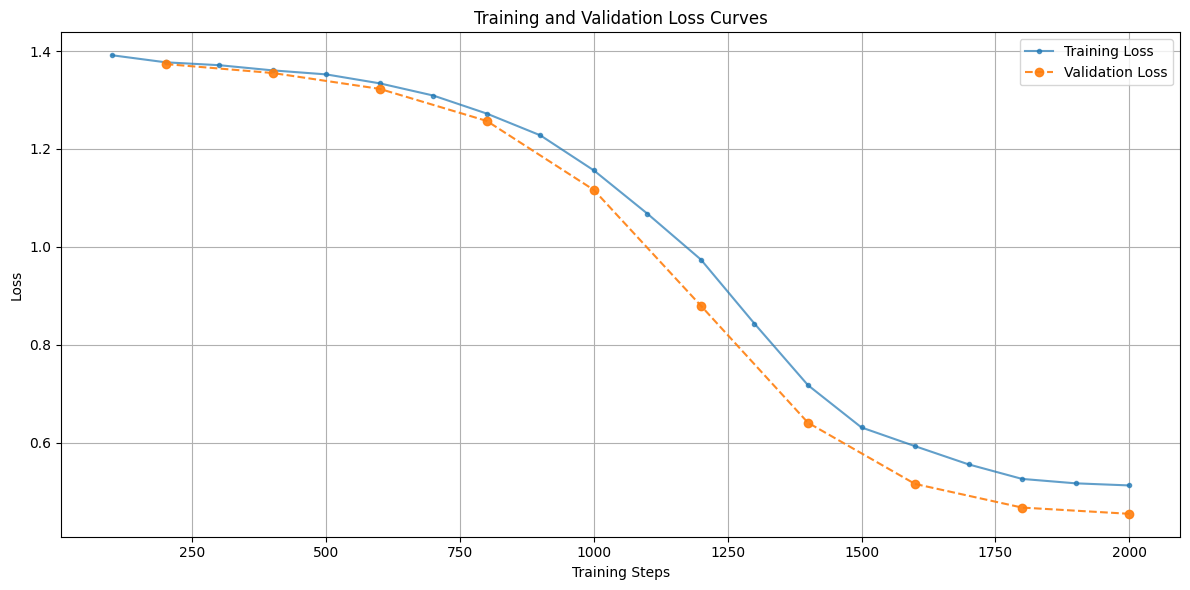


Evaluating best trained model on the validation set...


Starting evaluation (Labelled: True)...


Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Final accuracy on validation set: 0.8930


In [10]:
# Training Execution & Plotting
print("Starting training...")
final_accuracy_eval_set = float('nan')
train_result = None

try:
    # Start training
    train_result = trainer.train()
    print("Training finished.")
    trainer.save_model() # Save the trained LoRA adapter
    print(f"Trained LoRA adapter saved to {current_output_dir}")

    # Plot Loss Curves
    if train_result and hasattr(trainer.state, "log_history"):
        print("Plotting loss curves...")
        log_history = trainer.state.log_history
        train_steps, train_losses, eval_steps, eval_losses = [], [], [], []
        try:
            for log in log_history:
                if 'loss' in log: # Training log
                    train_steps.append(log['step'])
                    train_losses.append(log['loss'])
                elif 'eval_loss' in log: # Evaluation log
                    eval_steps.append(log['step'])
                    eval_losses.append(log['eval_loss'])

            plt.figure(figsize=(12, 6))
            if train_steps and train_losses:
                plt.plot(train_steps, train_losses, label='Training Loss', marker='.', linestyle='-', alpha=0.7)
            if eval_steps and eval_losses:
                plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='o', linestyle='--', alpha=0.9)

            if not train_steps and not eval_steps:
                 print("Warning: No loss data found in history to plot.")
            else:
                plt.title('Training and Validation Loss Curves')
                plt.xlabel('Training Steps')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plot_path = os.path.join(current_output_dir, "loss_curves.png")
                plt.savefig(plot_path)
                print(f"Loss curves saved to: {plot_path}")
                plt.show() # Display plot in notebook

        except ImportError:
             print("Matplotlib not found. Cannot plot loss curves. pip install matplotlib")
        except Exception as plot_e:
             print(f"Error plotting loss curves: {plot_e}")
    else:
        print("Skipping loss curve plotting (no training result or log history).")
    # --- End Plotting ---

    # Evaluate the best model on the validation set
    print("\nEvaluating best trained model on the validation set...")
    eval_metrics, _ = evaluate_model(
        trainer.model,
        eval_dataset,
        labelled=True,
        batch_size=training_args.per_device_eval_batch_size,
        data_collator=data_collator
    )
    final_accuracy_eval_set = eval_metrics.get('accuracy', float('nan'))
    print(f"Final accuracy on validation set: {final_accuracy_eval_set:.4f}")

except Exception as e:
    print(f"!!! ERROR during training/evaluation: {e}")
    import traceback
    traceback.print_exc()

In [11]:
# Memory Cleanup
print("Cleaning up training resources...")

try:
    del model
    del peft_model
    del trainer
except NameError:
    print("Some training objects might not have been initialized.")

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared.")
else:
    print("CUDA not available, skipping cache clear.")

Cleaning up training resources...
CUDA cache cleared.


In [12]:
# Load Trained Model & Merge
print(f"\nLoading best fine-tuned LoRA adapter from: {current_output_dir}")

try:
    # Load the base model again
    base_inference_model = RobertaForSequenceClassification.from_pretrained(
        base_model, num_labels=num_labels, id2label=id2label, label2id=label2id
    )

    # Load the LoRA adapter weights onto the base model
    inference_model = PeftModel.from_pretrained(base_inference_model, current_output_dir)
    print("PEFT adapter loaded successfully.")

    # Merge LoRA weights for standard inference
    print("Merging LoRA weights into the base model...")
    inference_model = inference_model.merge_and_unload()
    print("Weights merged. Model is now standard RobertaForSequenceClassification.")

    if torch.cuda.is_available():
        print("Moving merged model to CUDA")
        inference_model.to('cuda')
    else:
         print("CUDA not available, using CPU for merged model.")

except Exception as e:
    print(f"Error during model loading/merging: {e}")
    inference_model = None
    import traceback
    traceback.print_exc()


Loading best fine-tuned LoRA adapter from: roberta_agnews_finetuned


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT adapter loaded successfully.
Merging LoRA weights into the base model...
Weights merged. Model is now standard RobertaForSequenceClassification.
Moving merged model to CUDA


In [16]:
# Evaluate on Test Set

if 'inference_model' in locals() and inference_model is not None:
    print("\nEvaluating the merged model on AG News test set subset...")
    try:
        testset = load_dataset('ag_news', split='test')
        tokenized_testset = testset.map(preprocess, batched=True, remove_columns=["text"])
        tokenized_testset = tokenized_testset.rename_column("label", "labels")

        subset_size = 7600
        indices = torch.arange(subset_size)
        tokenized_testset_sub = data_utils.Subset(tokenized_testset, indices)
        print(f"Evaluating on 7600 samples from the test set.")

        test_eval_metrics, _ = evaluate_model(
            inference_model,
            tokenized_testset_sub,
            labelled=True,
            batch_size=64,
            data_collator=data_collator
        )
        final_accuracy_test_set = test_eval_metrics.get('accuracy', float('nan'))
        print(f"\nAccuracy on test subset: {final_accuracy_test_set:.4f}")

    except Exception as e:
        print(f"Error during test set evaluation: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Skipping test set evaluation because the inference model was not loaded successfully.")


Evaluating the merged model on AG News test set subset...
Evaluating on 7600 samples from the test set.
Starting evaluation (Labelled: True)...


Evaluating:   0%|          | 0/119 [00:00<?, ?it/s]


Accuracy on test subset: 0.8822


In [14]:
# Inference on Unlabelled Data

if 'inference_model' in locals() and inference_model is not None:
    print(f"\nLoading unlabelled data from: {unlabelled_data_path}")
    try:
        # Check if file exists before trying to load
        if not os.path.exists(unlabelled_data_path):
             raise FileNotFoundError(f"Unlabelled data file not found at {unlabelled_data_path}")

        loaded_object = pd.read_pickle(unlabelled_data_path)
        original_ids = None
        unlabelled_hf_dataset = None

        # Handle DataFrame or Dataset loaded from pickle
        if isinstance(loaded_object, pd.DataFrame):
            print("Pickle contained a pandas DataFrame.")
            if 'text' not in loaded_object.columns:
                raise ValueError("Unlabelled DataFrame must contain a 'text' column.")
            unlabelled_hf_dataset = Dataset.from_pandas(loaded_object)
            if 'ID' in loaded_object.columns: original_ids = loaded_object['ID'].values
        elif isinstance(loaded_object, Dataset):
            print("Pickle contained a Hugging Face Dataset.")
            unlabelled_hf_dataset = loaded_object
            if 'text' not in unlabelled_hf_dataset.column_names:
                raise ValueError("Unlabelled Dataset must contain a 'text' column.")
            if 'ID' in unlabelled_hf_dataset.column_names:
                try: original_ids = list(unlabelled_hf_dataset['ID'])
                except Exception: print("Warning: Could not extract 'ID' column reliably.")
        else:
            raise TypeError(f"Unexpected object type in pickle: {type(loaded_object)}")

        print("Tokenizing unlabelled data...")
        # Define columns to remove after tokenization
        columns_to_remove = [col for col in unlabelled_hf_dataset.column_names if col != 'ID']
        if 'text' not in columns_to_remove and 'text' in unlabelled_hf_dataset.column_names:
             columns_to_remove.append('text')

        tokenized_unlabelled_dataset = unlabelled_hf_dataset.map(
            preprocess, batched=True, remove_columns=columns_to_remove
        )

        print("\nRunning inference on unlabelled data...")
        # Get predictions (tensor) using the evaluate function in unlabelled mode
        preds = evaluate_model(
            inference_model,
            tokenized_unlabelled_dataset,
            labelled=False,
            batch_size=8,
            data_collator=data_collator
        )
        print("Inference on unlabelled data finished.")

    except FileNotFoundError as e:
        print(f"Error: {e}")
        preds = None 
    except Exception as e:
        print(f"Error during unlabelled data processing or inference: {e}")
        preds = None
        import traceback
        traceback.print_exc()
else:
    print("Skipping unlabelled data inference because the inference model was not loaded successfully.")
    preds = None


Loading unlabelled data from: test_unlabelled.pkl
Pickle contained a Hugging Face Dataset.
Tokenizing unlabelled data...


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]


Running inference on unlabelled data...
Starting evaluation (Labelled: False)...


Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]

Inference on unlabelled data finished.


In [15]:
# Save Predictions

if 'preds' in locals() and preds is not None and len(preds) > 0:
    print("\nSaving predictions...")
    try:
        preds_numpy = preds.cpu().numpy()

        # Prepare IDs for output CSV
        if 'original_ids' in locals() and original_ids is not None and len(original_ids) == len(preds_numpy):
            output_ids = original_ids
            print("Using original IDs from input data.")
        else:
            if 'original_ids' in locals() and original_ids is not None:
                 print(f"Warning: ID length mismatch or IDs not loaded. Generating sequential IDs.")
            else:
                 print("Generating sequential IDs for output.")
            output_ids = range(len(preds_numpy))

        # Create output DataFrame and save to CSV
        df_output = pd.DataFrame({'ID': output_ids, 'Label': preds_numpy})
        output_csv_path = os.path.join(current_output_dir, "lora_inference.csv")
        df_output.to_csv(output_csv_path, index=False)
        print(f"Inference complete. Predictions saved to: {output_csv_path}")

    except Exception as e:
        print(f"Error during prediction saving: {e}")
        import traceback
        traceback.print_exc()

elif 'preds' in locals() and preds is not None and len(preds) == 0:
    print("No predictions were generated, skipping saving.")
else:
     print("Skipping prediction saving because predictions were not generated successfully.")


Saving predictions...
Generating sequential IDs for output.
Inference complete. Predictions saved to: roberta_agnews_finetuned/lora_inference.csv
